Эксперимент проходил  с 2022-01-28 по 2022-02-03 включительно. Для эксперимента были задействованы 0 и 1 группы.  
В 1 группе был использован новый алгоритм рекомендации постов, 0 группа использовалась в качестве контроля. 

Проверим, появились ли статистически значимые различия в CTR у групп 0 и 1.

Как можно сравнить CTR:
1. Посчитать CTR для каждого пользователя в друх группах и сравнить группы по критерию Манна Уитни.
1. Посчитать CTR для каждого пользователя в друх группах и сравнить группы t-тестом (если величина выборок позволяет).
1. Сравнить общий CTR в друх группах, используя Bootstrap.

In [3]:
from CH import Getch
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np

In [4]:
query = '''
        select user_id, exp_group, 
        countIf(user_id, action = 'like') as likes, 
        countIf(user_id, action = 'view') as views, 
        likes / views as ctr
        from {db}.feed_actions
        where toDate(time) >= '2022-01-28' and  toDate(time) <= '2022-02-03'
        and exp_group in (0, 1)
        group by user_id, exp_group
        '''
df = Getch(query).df

In [5]:
df.head()

,user_id,exp_group,likes,views,ctr
0,26117,1,5,21,0.238095
1,138232,1,5,29,0.172414
2,49204,1,10,62,0.161290
3,49286,1,7,19,0.368421
4,145957,1,54,129,0.418605


In [6]:
df0 = df[df.exp_group == 0]
df1 = df[df.exp_group == 1]

count    12997.000000
mean         0.221955
std          0.087870
min          0.000000
25%          0.166667
50%          0.208333
75%          0.266667
max          0.769231
Name: ctr, dtype: float64

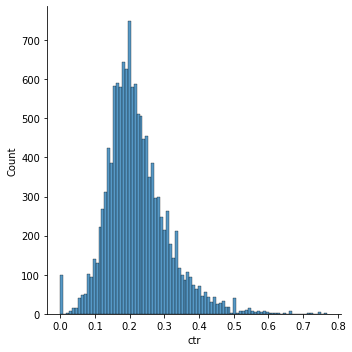

In [7]:
sns.displot(df0.ctr)
df0.ctr.describe()

count    13002.000000
mean         0.236486
std          0.090146
min          0.000000
25%          0.178082
50%          0.224138
75%          0.285714
max          0.800000
Name: ctr, dtype: float64

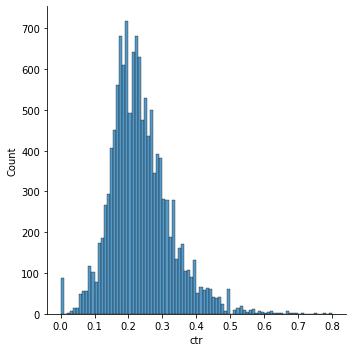

In [8]:
sns.displot(df1.ctr)
df1.ctr.describe()

## Промежуточные выводы
Можно заметить, что среднее значение CTR у экспериментальной группы 1 выше, чем у контрольной группы 0. 
Теперь необходимо проверить, что различия в CTR у двух групп являются статистически значимыми.

Возьмем две гипотезы:
* H0 – распределение CTR в группах 0 и 1 статистически значимо не различается.
* H1 – распределение CTR в группах 0 и 1 статистически значимо различается.

Для начала используем статистические критериии:
* U-критерий Манна — Уитни.
* t-критерий Стьюдента.

**Примечание.** Распределение CTR имеет легкую ассиметрию и выбросы, однако мы все же можем использовать t-критерий, так как величина выборок достаточно велика (~13000).

In [9]:
stats.mannwhitneyu(df0.ctr, df1.ctr)

MannwhitneyuResult(statistic=75455843.5, pvalue=1.9101702958848542e-50)

In [10]:
stats.ttest_ind(df0.ctr, df1.ctr)

Ttest_indResult(statistic=-13.161104283251186, pvalue=1.9646203782402242e-39)

P-value стремится к 0 –> мы можем отклонить нулевую гипотезу.
**Вывод**: CTR в группах 0 и 1 статистически значимо различается.

Для дополнительной проверки сравним общий CTR в выборках. Для этого из двух групп будем последовательно выбирать 
подвыборки из 500 юзеров и находить среди них общий CTR. Затем посмотрим на распределение p-value по выборкам.

In [11]:
# Функция возвращает доверительный интервал CTR и его среднее значение, а также визуализирует распределение CTR

def bootstrap_global_ctr(df, n_values = 5000):
    global_ctr = np.zeros(n_values)
    for i in range(n_values):
        subsample = df.sample(frac = 0.5, replace=True)
        global_ctr[i] = subsample.likes.sum() / subsample.views.sum()
        
    sns.displot(global_ctr)
    plt.xlabel('Global CTR')
    
    return [
        pd.Series(global_ctr).quantile(0.05),
        pd.Series(global_ctr).mean(),
        pd.Series(global_ctr).quantile(0.95)
    ]
            

[0.21152508498352107, 0.21309185325507843, 0.21468627477157537]

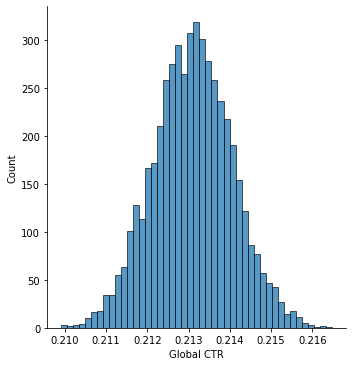

In [12]:
bootstrap_global_ctr(df0)

[0.22833059775681522, 0.22990517325477805, 0.23151653690948917]

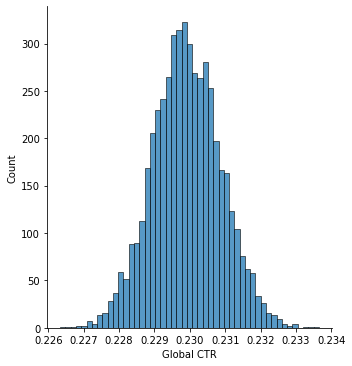

In [13]:
bootstrap_global_ctr(df1)

Доверительные интервалы не пересекаются, что дополнительно подтверждает, что CTR в двух группах различается.

**Важно!** Хоть при внедрении нового алгоритма и увеличился CTR, но есть вероятность, что при этом уменьшилось количество просмотров. Необходимо это проверить перед тем, как раскатывать алгоритм на всю аудиторию.

Проверим это также с помощью критерия Манна Уитни, t-теста и Bootstrap.

In [16]:
stats.mannwhitneyu(df0.views, df1.views)

MannwhitneyuResult(statistic=84514942.0, pvalue=0.9717276363684261)

In [17]:
stats.ttest_ind(df0.views, df1.views)

Ttest_indResult(statistic=0.1855745874228441, pvalue=0.8527798314430739)

In [28]:
# В этот раз будем проверять каждую подвыбоку из просмотров критерием Манна Уитни и проверим, в каком проценте случаев p-value
# будет меньше или равен 0.05

def bootstrap_views(df0, df1, n_values = 500, tests_count = 7000):
    p_value = np.zeros(tests_count)
    p_less = 0
    for i in range(tests_count):
        subsample0 = df0.sample(n=n_values, replace=True)
        subsample1 = df1.sample(n=n_values, replace=True)
        p_value[i] = stats.mannwhitneyu(subsample0, subsample1).pvalue
        if p_value[i] <= 0.05:
            p_less += 1
    sns.displot(p_value)
    plt.xlabel('p-value')
    
    return p_less / tests_count
    

Процент t-тестов, в которых p-value оказался меньше или равен 0.05:  4.56 %


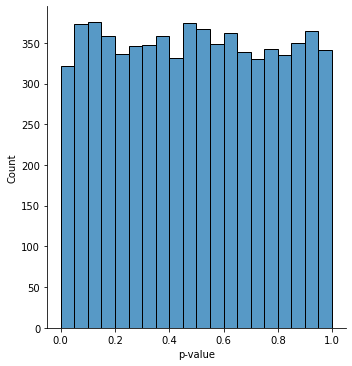

In [31]:
print('Процент t-тестов, в которых p-value оказался меньше или равен 0.05: ', 
      np.round(bootstrap_views(df0.views, df1.views)*100, 2), '%')

Сравнение просмотров в двух группах по критерию Манна Уитни и t-тестом не позволило отклонить нулевую гипотезу о том, что между выборками нет статистически значимых различий (p-value больше 0.05). Также при сравнении подвыборок методом Bootstrap p-value оказался меньше или равен 0.05 лишь в 4.56% случаев. 

Это подтверждает, что при внедрении нового алгоритма **количество просмотров не изменилось**. **CTR** при этом **вырос**.

**Вывод**: рекомендуется раскатить новый алгоритм на всех пользователей.
